In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm, entropy
import scipy.stats as ss
from sklearn.model_selection import KFold

Ack: this notebook has been written by Ileana Buhan and Olivier Bronchain. Discussions with Kostas Papagiannopoulos were instrumentantal for deriving the formula for mutual information applied to SCA.

## Modeling the True Leakage


The notation used here is chosen to match the notation used in the paper of Bronchain et al. https://eprint.iacr.org/2019/132.pdf

Simulations settings and notations:
* Random variable letters are denoted with capital letters and their realisation with lower cases.
* We are interested in the leakage $L$ associated to an intermediate (sensible) variable $K$. In the following, we take $K$ as a 2-bit binary variable, so $K$ can take 4 values.
* We assume the discrete variable $K$ follows a uniform distribution.  
* For a given value of $K$ denoted $k$, the probability to observe $l$ is mathematically written as $p(l|k)$ and in code is refered to as$p_l_k$. In our case, the samples are generated according to four conditional probabilities, one for each value of $k$.
* We assume normal distribution, with a given mean and std. This means that each $p(l|k)$ follows a Gaussian distribution. This distribution is called the "True distribution" because it does not suffer from estimation issues.
* Leakage samples are generated according to these "True distributions". 


In [2]:
number_bits=2
number_classes=2**number_bits #the total number of values taken by the target intermediate

#setting the probability of the key
p_k= np.ones(number_classes, dtype=np.float64)
p_k/=number_classes


#defining the values for p(l|k), for the 4 different values of k
norm_params = np.array([[1, 4],[0,2], [0, 5], [-1, 4]])
#norm_params = np.array([[0, 0.1],[1, .1],[2, .1], [3, .1]])

## Lets measure!

To simulate the measurement process, we sample data from the "True distributions".


In [3]:
def measure_data(p_k,norm_params,number_samples=100):
    """ 
    p_k = discrete probability distribution if K
    norm_params = parameters of the true distributions
    number_samples = number of samples for each class of K. This corresponds to n^k_p

    returns leakage samples correponding to the target intermediate K and norm_params
    """
    data = {}
    for k, _ in enumerate(p_k):
        data[k]= ss.norm.rvs(*(norm_params[k]),size=number_samples)
    return data

true_data=measure_data(p_k, norm_params)

### Visualize the histogram of the measured data

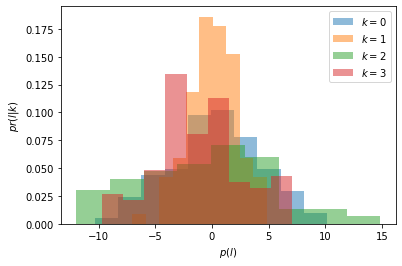

In [4]:
def visualize_distribution_points(data_dictionary, b='auto'):
    """
    plot the histogram of the elements in the lists
    as a function of the key values
    
    data_dictionary =  dictionary of lists, the key is the value of the keys and values are the samples l
                    = k: [l_0,l_1,....l_n]
    
    """
    for k in data_dictionary:

        plt.hist(data_dictionary[k], bins=b,density=True,alpha = 0.5,label='$k = %d$'%k)
    plt.xlabel("$p(l)$")
    plt.ylabel("$pr(l|k)$")
    plt.legend()
    plt.show()

visualize_distribution_points(true_data)

## Calculating Mutual Information for SCA

### Notations:
* $H(K)$ is the entropy of $K$. If uniform, this corresponds to the number of bits in $K$.
* $H(K|L)$ is the conditional entropy. It is the entropy of $K$ given leakage $L$.
* $I(K;L)$ is the mutual information between $K$ and $L$ and it represents the amount of information the two variables provide about eachother.  These terms are related such that
$$H(K|L) = H(K) - I(K;L).$$

Calculating these terms requires to know the analytical form for the distribution of both $K$ and $L$.

### Interest for Side Channel
In side-channel context, it is interesting to learning $H(K|L)$ or equivalently $I(K;L)$ (since $H(K)$ is typically known in cryptographic contextm as $K$ is uniformly distributed). 

Informally,  $I(K;L)$ is the loss of entropy of $K$ given a leakage samples $L$. The data complexity of an attack can be approximated as the number of traces required to reduce the conditional entropy $H(K|L)$ to zero. Roughly, this gives:
$$N_{attack} \propto \frac{H(K)}{I(K;L)}.$$

### Deriving an expression for $I(K;L)$ in the context of SCA

As written above, the classic formula is  $I(K,L)=H(K)-H(K|L).$ A problem  for directly applying the formula is that we do not know the value of $H(K|L)$. Let see why. The classic formula for conditional entropy is: $$H(K|L)=\sum_{k,l} \color{red}{p(l)}\color{red}{p(k|l)}\log_2\color{red}{p(k|l)},$$ where the distributions marked in red are unknown. In the SCA scenario, we can only observe the following distributions:
* $p(k)$ the distribution of the secret variable, typically uniform.
* $p(l|k)$ can only be sampled from power or EM traces in a pratical context. Its estimation is next denoted as $\hat{p}(l|k)$. In a simulated setting, the analytical expression of this can be known and so $p(l|k) = \hat{p}(l|k)$. 

So how do we compute  mutual information ? An ingenuous solution is known, fear not! By applying Bayes law, we know that: $\color{red}{p(k|l)}\color{red}{p(l)}=p(l|k)p(k)$. This is better! We can now re-write the formula above as: $$H(K|L)=\sum_{k,l} p(k)p(l|k)log_2\color{red}{p(k|l)},$$ and we are left with only one distribution that we cannot observe namely $\color{red}{p(k|l)}$. 

However, by applying Bayes formula again, we can write $\color{red}{p(k|l)}= \frac{p(l|k)p(k)}{\color{red}{p(l)}}$and now, by applying the formula for computing marginal probabilities we have: $\color{red}{p(l)}=\sum_{k^{*}}p(l|k^{*})p(k^{*}).$ When the variable $K$ is uniformly distributed, we can write: $p(k|l)=\frac{p(l|k)}{\sum{k^*}p(l|k^*)}$

Finally, by combining all the pieces of the puzzle, we now have:

$$H(K|L)=\sum_{k,l} p(k)p(l|k)\log_2 \frac{p(l|k)p(k)}{\sum_{k^*}{p(l|k^*)} p(k^*)}.$$ 

### Computation of $I(K;L)$
In order to compute the previous expression in a side-channel context. One has access to the following:
* $n^k_p$ observed leakage from $p(l|k)$ where the $i$-th observation is denoted as $l^{k}_i$.
* $p(k)$ is typically known and uniformed.
* $\hat{p}(k|l)$ a model estimating the leakage distribution. This is used to compute the last term in the previous equation.

Then, the previous expression is computed by sampling with:
$$\hat{H}(K|L) = \sum_{k} p(k) \cdot \color{blue}{\sum_{i=1}^{n^k_p} \frac{1}{n^k_p}} \cdot \log_2 \color{green}{\frac{\hat{p}(l^k_i|k)p(k)}{\sum_{k^*}{\hat{p}(l^k_i|k^*)} p(k^*)}}$$
There, the blue part corresponds to the true leakage distribution that is sampled. The green term corresponds to the modeled distribution.

Lets go and implement the formula to compute $\hat{I}(K;L)$.

In [5]:
def information(p_k,data,model):
    """
    implements I(K;L)
    
    p_k = the distribution of the sensitive variable K
    data = the samples we 'measured'. It its the n^k_p samples from p(l|k)
    model = the estimated model \hat{p}(l|k).

    returns an estimated of mutual information
    """
    N_k = len(p_k)              #N_k is the number of possible values for $K$
    acc = entropy(p_k,base=2)   #we initialize the value with H(K)
    for k in range(N_k):
        l = data[k]
        p_l_k = np.zeros((N_k,len(l)))
        for k_star in range(N_k):
            p_l_k[k_star,:] = ss.norm.pdf(l,*(model[k_star]))
        p_l=np.sum(p_k*(p_l_k).T,axis=1)
        p_k_l =  p_k[k]*p_l_k[k,:]/ p_l
        acc += p_k[k] * np.mean(np.log2(p_k_l))
    return acc
import statsmodels.api as sm

data=measure_data(p_k, norm_params, number_samples=10000)
MI = information(p_k,data,norm_params)
print("MI is %f"%(MI))

MI is 0.145023


## Bounds on Mutual Information

The following information graphs allows to compute all the information metrics according to what we set to the inputs:

* 𝑀𝐼 : the model and the data should perfectly match ($p(l|k) = \hat{p}(l|k)$). Therefore, not feasible on real measurements because you never know perfectly the model
* 𝑃𝐼 : the model $\hat{p}(l|k)$ is estimated $n^k_t$ samples which are different than the $n^k_p$ samples. From a fixed size data set, PI is so computed with cross-validation.
* 𝐻𝐼 : the model $\hat{p}(l|k)$ is estimated on data than the $n^k_p$ samples.

What's the relation between all these for  𝑛𝑡←∞ :

* 𝐻𝐼  is an average upper bound to  𝑀𝐼 if the model estimation is non parametric ($\hat{p}(k|l)$ converges to $p(k|l)$ whate ever $p(k|l)$).
* 𝑃𝐼  is an average lower bound to  𝑀𝐼 . The two matches perfectly if the model is non parametric or if no modeling error is introduced (ie. we assume leakage is Gaussian and the real leakage is perfectly Gaussian).

Therefore, if the models used are non parametrics, both  𝐻𝐼  and  𝑃𝐼  converges to  𝑀𝐼  and  𝑃𝐼  is a lower bound to  𝑀𝐼  and  𝐻𝐼  is the upper bound.

In [6]:
data_build_model=measure_data(p_k, norm_params,number_samples=1000)
data_fresh=measure_data(p_k, norm_params,number_samples=1000)


esti_models = [None for i in p_k]
for k in range(len(p_k)):
    esti_models[k] = [np.mean(data_build_model[k]),np.std(data_build_model[k])]

PI = information(p_k,data_fresh,esti_models)
HI = information(p_k,data_build_model,esti_models)
print("PI is %f"%(PI))
print("HI is %f"%(HI))
print("MI is %f"%(MI))

PI is 0.133190
HI is 0.135488
MI is 0.145023


## Convergence plots for PI and HI

Next, we show convergence of PI and HI. This allows to observe the convergence of the used estimator for given data.

In [7]:
N_s= 1000
n_fold = 10
N_av = 50

def keep_measures(p_k,data_orig,I):
    """ p_k: discrete probability distribution if K
        data_orig: set from which we select samples
        I: the indexes of the measures to keep

        returns a slice of data_orig
    """
    data = [data_orig[k][I] for k in range(len(p_k))]
    return data

### Generate data
data=measure_data(p_k, norm_params,number_samples=100000)

# data are exactly the one from the model, 
# this can not be done in real settings because norm_params are unkown
MI = information(p_k,data,norm_params)

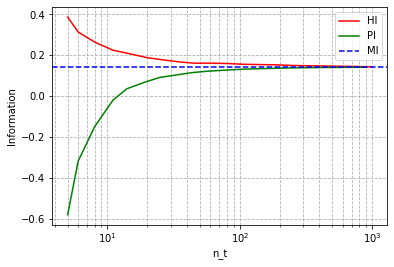

In [9]:
# Estimating PI and HI for various sampling efforts
N_HI = np.logspace(np.log10(5),np.log10(N_s),20,dtype=int)
N_PI = np.logspace(np.log10(5),np.log10(N_s*(1-1/n_fold)),20,dtype=int)
PI = np.zeros(len(N_HI))
HI = np.zeros(len(N_PI))
kf = KFold(n_splits=n_fold)


for av in range(N_av):
    # fresh data to compute the HI and PI on
    data = measure_data(p_k, norm_params,number_samples=N_HI[-1])
    
    #HI
    for i,n_p in enumerate(N_HI):
        # Keep the n first data samples
        data_n = keep_measures(p_k=p_k,data_orig=data,I=np.arange(n_p))
        
        #estimate model with n samples
        esti_models = [None for i in p_k]
        for k in range(len(p_k)):
            esti_models[k] = [np.mean(data_n[k]),np.std(data_n[k])]
        HI[i] += information(p_k,data_n,esti_models)

    #PI
    PI_x = np.zeros(PI.shape)
    for train_index, test_index in kf.split(range(N_s)):
        data_model = keep_measures(p_k=p_k,data_orig=data,I=train_index)
        data_p = keep_measures(p_k=p_k,data_orig=data,I=test_index)

        for i,n in enumerate(N_PI):
            data_model_nt = keep_measures(p_k=p_k,data_orig=data_model,I=range(n))
    
            #generate fresh samples
            esti_models = [None for i in p_k]
            for k in range(len(p_k)):
                esti_models[k] = [np.mean(data_model_nt[k]),np.std(data_model_nt[k])]
            PI_x[i] += information(p_k,data_p,esti_models)
    PI += PI_x/n_fold
HI /= N_av
PI /= N_av

#visualize plots
plt.figure()
plt.semilogx(N_HI,HI,label="HI",color="r")
plt.semilogx(N_PI,PI,label="PI",color="g")
plt.axhline(MI,label="MI",color="b",ls="--")
plt.grid(True,which="both",ls="--")
plt.xlabel("n_t")
plt.ylabel("Information")
plt.legend()
plt.show()